## Assignment 3a - Task 2: Collaborative Filtering

### Rizal Hamdan Arigusti, a1939989, Version 03
### Group 14

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### 1. Load Dataset

In [86]:
dataframe = pd.read_csv("../../data/Groceries data train.csv")

dataframe = dataframe.rename(columns={"User_id": "user_id", "Date": "date","itemDescription": "item_description"})

In [87]:
dataframe = dataframe.dropna(how='all')
dataframe['date'] = pd.to_datetime(dataframe['date'], format="%d/%m/%Y")
missing_per_column = dataframe.isnull().sum()
print("Missing values per column:\n", missing_per_column)

Missing values per column:
 user_id             0
date                0
item_description    0
year                0
month               0
day                 0
day_of_week         0
dtype: int64


In [88]:
def generate_transaction_history(dataset):
    transaction_history = dataset.groupby(['user_id', 'date', "year", "month", "day", "day_of_week"]).agg({
        'item_description': list
    }).reset_index()

    transaction_history = transaction_history.rename(columns={"item_description": "items"})
    return transaction_history

full_transaction_history = generate_transaction_history(dataframe)

### 2. Exploratory Data Analyis

#### 2.1 User-Items Ratio and Sparsity Check

Data Sparsity is another challenge that might be encountered when developing a recommender system. It is a phenomenon where users only rated a limited number of items (Guo 2012, p. 361). This might lead the recommender system to hardly find meaningful relationships between users and items. Therefore, to calculate the sparsity of the train dataset, a formula from (Huang, Chen & Zeng 2004, p.119) was adapted.


In [89]:
n_users = dataframe["user_id"].nunique()
n_items = dataframe["item_description"].nunique()

n_interactions = dataframe.groupby(["user_id", "item_description"]).size().shape[0]
n_possible_interactions = n_users * n_items

density = n_interactions / n_possible_interactions
sparsity = 1 - density


print(f"Sparsity: {sparsity:.2f}")
print(f"Density: {density:.2f}")
print("=" * 25)
print(f"Number of Users: {n_users}")
print(f"Number of Items: {n_items}")
print(f"User-Item Ratio: {n_users/n_items:.2f}")

Sparsity: 0.97
Density: 0.03
Number of Users: 3493
Number of Items: 167
User-Item Ratio: 20.92


The calculation resulted in 97% data sparsity, based on 3493 of users and 167 of items, and categorized as high data sparsity. In addition, the significant higher number of users compared to items leads to a tall user-item (utility) matrix. These two observations become the underlying basis to decide the type of collaborative filtering recommender system that was developed.


#### 2.2 Number of Transaction of Each User

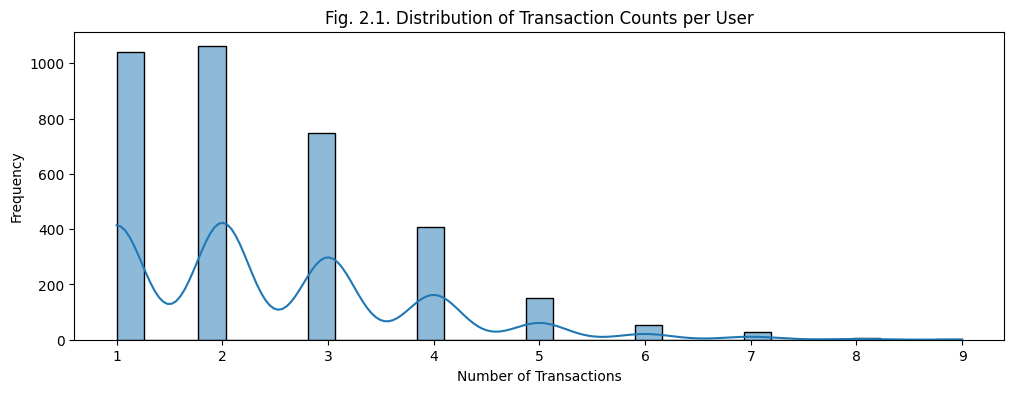

In [90]:
transaction_counts = full_transaction_history.groupby('user_id').size().reset_index(name='transaction_count')
plt.figure(figsize=(12, 4))
sns.histplot(transaction_counts['transaction_count'], kde=True)
plt.title('Fig. 2.1. Distribution of Transaction Counts per User')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

#### 2.3 Item Popularity Distribution

One of the challenges when developing a recommender system is the long-tail problem. This problem might lead to the condition where less-popular items (in the tail) will be rarely recommended even if they may be highly relevant to some users. Therefore, to check whether the used train dataset has this characteristic, an item popularity distribution graph was made. This graph can be seen on Fig. 2.2 below.


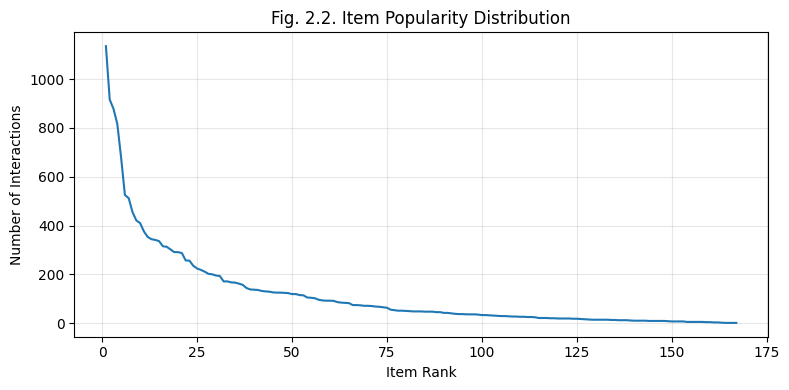

In [91]:
### Reference: ChatGPT 1
item_counts = dataframe['item_description'].value_counts().reset_index()
item_counts.columns = ['item_description', 'transaction_count']

# Sort by interaction count (descending)
item_counts = item_counts.sort_values('transaction_count', ascending=False)

# Add rank column
item_counts['rank'] = range(1, len(item_counts) + 1)

# Basic plot of interactions by item (ordered by popularity)
plt.figure(figsize=(8, 4))
plt.plot(item_counts['rank'], item_counts['transaction_count'])
plt.title('Fig. 2.2. Item Popularity Distribution')
plt.xlabel('Item Rank')
plt.ylabel('Number of Interactions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

As can be seen on Figure 2.2 above, the graph clearly shows a long-tail distribution. It indicates only a small number of popular items that are frequently purchased by the users. Therefore, this observation is one of the important considerations when making further decisions.


#### 2.4. Most Purchased Items

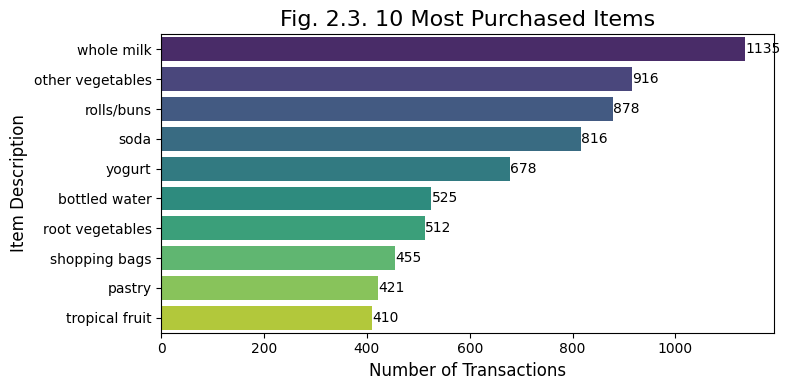

In [92]:
### Reference: ChatGPT 3

top_10_items = item_counts.head(10)

plt.figure(figsize=(8, 4))

sns.barplot(x='transaction_count', y='item_description', data=top_10_items, palette='viridis', hue='item_description')
plt.title('Fig. 2.3. 10 Most Purchased Items', fontsize=16)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Item Description', fontsize=12)

for i, v in enumerate(top_10_items['transaction_count']):
    plt.text(v + 0.5, i, str(v), va='center')
plt.tight_layout()
plt.show()

Understanding the most purchased items is important as it might provide an insight into how the recommender system works when dealing with cold-start users. Recommending the most purchased items also can be an alternative when there are no recorded user-item interactions. Figure 2.3 illustrates several most purchased items which were later used when recommending a cold-start user.


### 3. Preprocessing

In [93]:
def split_dataset_by_date(df, ratio):
    df = df.sort_values("date")
    total_rows = len(df)
    target_split = int(total_rows * ratio)
    cumulative_count = 0
    for date, count in df['date'].value_counts().sort_index().items():
        cumulative_count += count
        if cumulative_count >= target_split:
            split_date = pd.to_datetime(date)
            train = df[df['date'] < split_date]
            dev = df[df['date'] >= split_date]
            return train, dev, split_date
    return df, pd.DataFrame(), None


In [94]:
train_set, dev_set, split_date = split_dataset_by_date(dataframe, ratio=0.7)

In [95]:
def generate_transaction_history(dataset):
    transaction_history = dataset.groupby(['user_id', 'date', "year", "month", "day", "day_of_week"]).agg({
        'item_description': list
    }).reset_index()

    transaction_history = transaction_history.rename(columns={"item_description": "items"})
    return transaction_history

train_transaction_history = generate_transaction_history(train_set)

#### 3.1 Generate Utility Matrix

In [96]:
def generate_utility_matrix(dataset):
    utility_matrix = pd.crosstab(dataset['user_id'].astype(int), dataset['item_description'])
    utility_matrix.replace(0, np.nan, inplace=True)
    return utility_matrix

In [97]:
train_utility_matrix = generate_utility_matrix(train_set)
dev_utility_matrix = generate_utility_matrix(dev_set)

In [98]:
def mean_norm(array):
    # print(type(array))
    mean = np.mean(array)
    norm_array = [freq - mean for freq in array]
    return pd.Series(norm_array, index=array.index), mean


def normalize_utility_matrix(utility_matrix, type="item"):
    axis = 0 if type == "item" else 1
    mean_dict = {}
    
    def apply_mean_norm(x):
        norm_x, mean = mean_norm(x)
        mean_dict[x.name] = mean  # Store the mean for this item/user
        return norm_x
        
    utility_matrix_normalized = utility_matrix.apply(apply_mean_norm, axis=axis)
    return utility_matrix_normalized, pd.Series(mean_dict)
    

In [99]:
train_norm_utility_matrix_item_based, train_set_means_item_based = normalize_utility_matrix(train_utility_matrix.copy()) 
train_norm_utility_matrix_item_based

item_description,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
user_id,,,,,,,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149341,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149341,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149341,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.850659,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149341,NaN,NaN


### 4. Collaborative Filtering

#### 4.1 Standard Collaborative Filtering

In [100]:
from sklearn.metrics.pairwise import cosine_similarity

def generate_item_similarity_table(utility_matrix):
    filled_matrix = utility_matrix.fillna(0).T  # Transpose: items as rows
    
    similarity_matrix = cosine_similarity(filled_matrix)
    
    similarity_df = pd.DataFrame(similarity_matrix, 
                                 index=filled_matrix.index, 
                                 columns=filled_matrix.index)
    
    return similarity_df

In [101]:
def predict_rating(item_similarity_matrix, utility_matrix, user_purchased_items, target_user, target_item, n_neighbour=10):
    similar_items = item_similarity_matrix[target_item].drop(index=target_item)
    top_k_items = similar_items.sort_values(ascending=False).head(n_neighbour)
    
    weighted_sum = 0
    similarity_sum = 0
    
    if len(user_purchased_items) < 1:
        return  utility_matrix[target_item].mean() 
    
    for item, similarity in top_k_items.items():
        if item in user_purchased_items:
            rating = utility_matrix.loc[target_user, item]
            if not np.isnan(rating):
                weighted_sum += similarity * rating
                if similarity > 0:
                    similarity_sum += similarity

    return weighted_sum / similarity_sum if similarity_sum != 0 else 0

def get_cf_recommended_items(target_user, 
                             utility_matrix,
                             item_similarity_matrix,
                             n_recommended_items=None, 
                             n_similar_neighbours = 10,
                             debug=False):
    
        all_user_ids = utility_matrix.index   
        user_unpurchased_items = []
        user_purchased_items = []
        if not target_user in all_user_ids:
            if debug:
                print("New User:", target_user)
            user_unpurchased_items = utility_matrix.columns 
        else:
            user_ratings_row = utility_matrix.loc[target_user]
            user_unpurchased_items = user_ratings_row[user_ratings_row.isna()].index.tolist()
            user_purchased_items = user_ratings_row[~user_ratings_row.isna()].index.tolist()
            
        rating_predictions = {}
        for target_item in user_unpurchased_items:
            predicted_rating = predict_rating(item_similarity_matrix, 
                                                     utility_matrix, 
                                                     user_purchased_items, 
                                                     target_user, 
                                                     target_item,
                                                     n_similar_neighbours,
                                                     )
            rating_predictions[target_item] = predicted_rating
        
        recommended_items = sorted(rating_predictions.items(), key=lambda x: x[1], reverse=True)
        if not n_recommended_items:
            return recommended_items
        return recommended_items[:n_recommended_items]

In [102]:
item_based_similarity_matrix = generate_item_similarity_table(train_norm_utility_matrix_item_based)
standard_cf_recommendation = get_cf_recommended_items(1050, 
                                                   train_utility_matrix, 
                                                   item_based_similarity_matrix, 
                                                   n_recommended_items=10, 
                                                   debug=True)
standard_cf_recommendation

[('UHT-milk', 2.0),
 ('canned beer', 2.0),
 ('citrus fruit', 2.0),
 ('dessert', 2.0),
 ('ham', 2.0),
 ('mustard', 2.0),
 ('onions', 2.0),
 ('rolls/buns', 2.0),
 ('sausage', 2.0),
 ('soda', 2.0)]

In [103]:


def extract_items_from_frozenset(frozenset_str):
        """Extract item names from frozenset string representation."""
        # Example: frozenset({'soda'}) -> ['soda']
        # Remove "frozenset(" from start and ")" from end
        items_str = frozenset_str.replace("frozenset(", "").rstrip(")")
        
        # Handle either {'item'} or {'item1', 'item2'} formats
        items = []
        if items_str:
            # Strip outer braces
            content = items_str.strip("{}")
            # Split by comma and clean up quotes
            for item in content.split(","):
                cleaned_item = item.strip().strip("'\"")
                if cleaned_item:
                    items.append(cleaned_item)
        
        return items
    
def get_association_rules_recommendations(purchased_items, association_rules, max_recommendations=50):
        recommendations = {}
        purchased_set = set(purchased_items)
        if len(purchased_set) < 1:
            all_consequents = []
            for _, rule in association_rules.iterrows():
                all_consequents.extend(extract_items_from_frozenset(rule['consequents']))

            most_common = Counter(all_consequents).most_common(max_recommendations)
            return [(item, 1) for item, _ in most_common]
            
        else:
            for _, rule in association_rules.iterrows():
                antecedent_items = extract_items_from_frozenset(rule['antecedents'])
                consequent_items = extract_items_from_frozenset(rule['consequents'])
                
                # Check if any purchased items are in the antecedent
                if any(item in purchased_set for item in antecedent_items):
                    for consequent_item in consequent_items:
                        # Skip if user already has this item
                        if consequent_item in purchased_set:
                            continue
                        rule_score = rule["composite_score_with_recency"]
                        
                        # Update recommendations
                        recommendations[consequent_item] = max(
                            recommendations.get(consequent_item, 0),
                            rule_score
                        )
            
            # Sort recommendations by score
            sorted_recommendations = sorted(
                recommendations.items(),
                key=lambda x: x[1],
                reverse=True
            )[:max_recommendations]
            
            return sorted_recommendations

In [104]:
def normalize_scores(recommendations):
    if not recommendations:
        return []
    max_score = max(score for _, score in recommendations)
    if max_score == 0:
        return [(item, 0.0) for item, _ in recommendations]
    return [(item, score / max_score) for item, score in recommendations]

def calculate_confidence_factor(k, t):
    alpha = min(t, k) / k * 0.9

    return alpha

def get_cf_rule_weight(user_transaction_history, n_recommended_items):
    history_length = len(user_transaction_history)

    user_history_weight = calculate_confidence_factor(n_recommended_items, history_length)
    cf_weight = user_history_weight
    rule_weight = 1 - user_history_weight
    
    return cf_weight, rule_weight

In [105]:
def weighted_hybrid_cf_recommended_items(utility_matrix, transaction_history, 
                                   association_rules, 
                                   cf_recommendations, 
                                   target_user):

        user_purchased_items = []
        user_transaction_history = []
        if target_user in utility_matrix.index.values: ## If user has transaction history
            user_ratings_row = utility_matrix.loc[target_user]
            user_purchased_items = user_ratings_row[~user_ratings_row.isna()].index.tolist()
            user_transaction_history = transaction_history[transaction_history["user_id"] == target_user]
    
        k = len(cf_recommendations)    
        cf_weight, rule_weight = get_cf_rule_weight(user_transaction_history, k)
        association_rules_recommendations = get_association_rules_recommendations(user_purchased_items, 
                                                                                  association_rules, 
                                                                                  max_recommendations=k)
        final_scores = {}
        
        # Normalize Both Recommendations
        cf_recs_norm = normalize_scores(cf_recommendations)
        ar_recs_norm = normalize_scores(association_rules_recommendations)
    
        for item, score in cf_recs_norm:
            final_scores[item] = score * cf_weight
            
        for item, score in ar_recs_norm:
            if item in final_scores:
                final_scores[item] += score * rule_weight
            else:
                final_scores[item] = score * rule_weight
        
        # Sort and return top recommendations
        top_recommendations = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:]
        return top_recommendations[:k]

In [106]:
association_rules = pd.read_csv("../../pattern_mining/recency_rules/rules_fpgrowth_recency.csv")


In [107]:
weighted_hybrid_cf_recommended_items(train_utility_matrix, 
                                     train_transaction_history, 
                                     association_rules, 
                                     standard_cf_recommendation, 
                                     1050)

[('soda', 0.8245192307692307),
 ('fruit/vegetable juice', 0.73),
 ('shopping bags', 0.6617730769230769),
 ('bottled water', 0.6242903846153846),
 ('whipped/sour cream', 0.571926923076923),
 ('whole milk', 0.489801923076923),
 ('root vegetables', 0.47548269230769225),
 ('UHT-milk', 0.27),
 ('canned beer', 0.27),
 ('citrus fruit', 0.27)]

#### 4.x Model Evaluation

In [108]:
def precision_recall_f1(recommended_items, actual_items):
    precisions = []
    recalls = []
    f1s = []

    for rec, act in zip(recommended_items, actual_items):
        rec_set = set(rec)
        act_set = set(act)
        
        true_positives = len(rec_set & act_set)
        precision = true_positives / len(rec_set) if rec_set else 0
        recall = true_positives / len(act_set) if act_set else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1s) / len(f1s)

    return avg_precision, avg_recall, avg_f1

In [109]:
user_ids_dev_set = set(dev_utility_matrix.index)
user_ids_train_set = set(train_utility_matrix.index)
n_neighbours = [k for k in range(5, 31, 5)]
results_dict = dict()
for k in n_neighbours:
    print(f"K Neighbour: {k}")
    cf_only_recommended_items = []
    hybrid_recommended_items = []
    actual_items = []
    count = 1
    for user_id in user_ids_dev_set:
        predicted_cf_recommendations = get_cf_recommended_items(user_id, train_utility_matrix, item_based_similarity_matrix, 
                                                                n_recommended_items=10, 
                                                                n_similar_neighbours=k)
        predicted_hybrid_recommendations = weighted_hybrid_cf_recommended_items(train_utility_matrix, train_transaction_history, 
                                                                        association_rules, 
                                                                        predicted_cf_recommendations, user_id)
        predicted_cf_recom_items = [recs_item[0] for recs_item in predicted_cf_recommendations]
        predicted_hybrid_recom_items = [recs_item[0] for recs_item in predicted_hybrid_recommendations]
        
        purchased_items_in_train = []
        if user_id in user_ids_train_set: # IF NOT COLD START USER
            user_row_utility_matrix_train = train_utility_matrix.loc[user_id] # Getting a row of specified user (getting all items of a user)
            purchased_items_in_train = user_row_utility_matrix_train[~user_row_utility_matrix_train.isna()].index.tolist()
        
        user_row_utility_matrix_dev = dev_utility_matrix.loc[user_id]
        purchased_items_in_dev = user_row_utility_matrix_dev[~user_row_utility_matrix_dev.isna()].index.tolist()
        
        # a list of items that appear in purchased_items_in_dev but not in purchased_items_in_train.
        purchased_items_only_in_dev = [item_name for item_name in purchased_items_in_dev if not item_name in purchased_items_in_train]
        
        cf_only_recommended_items.append(predicted_cf_recom_items)
        hybrid_recommended_items.append(predicted_hybrid_recom_items)
        actual_items.append(purchased_items_only_in_dev)
        count += 1
    
    baseline_cf_precision, baseline_cf_recall, baseline_f1 = precision_recall_f1(cf_only_recommended_items, actual_items)
    hybrid_cf_precision, hybrid_cf_recall, hybrid_f1 = precision_recall_f1(hybrid_recommended_items, actual_items)
    results_dict[k] = {
        "standard_cf": {
            "precision": baseline_cf_precision,
            "recall": baseline_cf_recall,
            "f1-score": baseline_f1
        },
        "hybrid_cf":{
            "precision": hybrid_cf_precision,
            "recall": hybrid_cf_recall,
            "f1-score": hybrid_f1
        }
    }

K Neighbour: 5
K Neighbour: 10
K Neighbour: 15
K Neighbour: 20
K Neighbour: 25
K Neighbour: 30


In [110]:
print(results_dict)

{5: {'standard_cf': {'precision': 0.044665948275862004, 'recall': 0.1536602166990098, 'f1-score': 0.06627899877714759}, 'hybrid_cf': {'precision': 0.06610991379310277, 'recall': 0.22893114877220458, 'f1-score': 0.09828989249536449}}, 10: {'standard_cf': {'precision': 0.045312499999999874, 'recall': 0.15639589397671294, 'f1-score': 0.06737361301501911}, 'hybrid_cf': {'precision': 0.06734913793103378, 'recall': 0.23326715041424062, 'f1-score': 0.1001690813317986}}, 15: {'standard_cf': {'precision': 0.04552801724137921, 'recall': 0.15645169754814153, 'f1-score': 0.06760397096279593}, 'hybrid_cf': {'precision': 0.06761853448275794, 'recall': 0.2336857646663679, 'f1-score': 0.10055331499522213}}, 20: {'standard_cf': {'precision': 0.0462823275862068, 'recall': 0.15894040854978353, 'f1-score': 0.06868950478397251}, 'hybrid_cf': {'precision': 0.06788793103448212, 'recall': 0.23450293420659774, 'f1-score': 0.10095556181449478}}, 25: {'standard_cf': {'precision': 0.047629310344827445, 'recall': 

In [113]:
### Reference: Chat GPT 10
def visualize_evaluation(k_list, precisions, recalls, f1_scores, title=""):
    plt.figure(figsize=(8, 5))
    plt.plot(k_list, precisions, marker='o', label='Precision')
    plt.plot(k_list, recalls, marker='o', label='Recall')
    plt.plot(k_list, f1_scores, marker='o', label='F1-Score')
    plt.title(title)
    plt.xlabel('K Neighbours')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

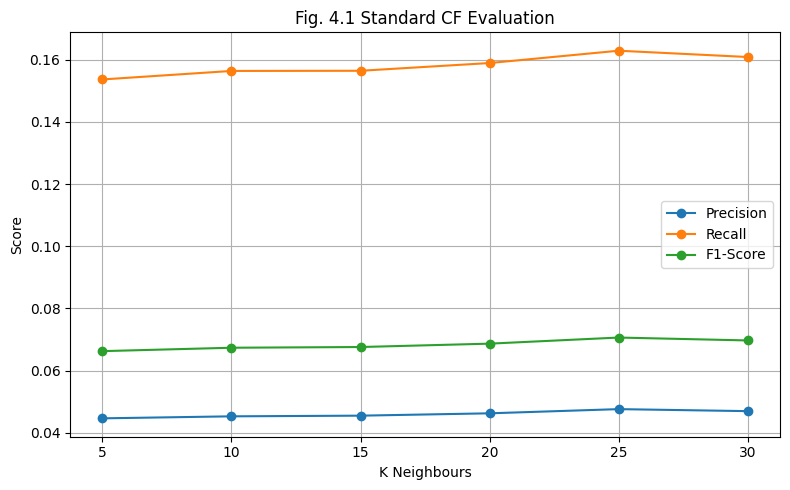

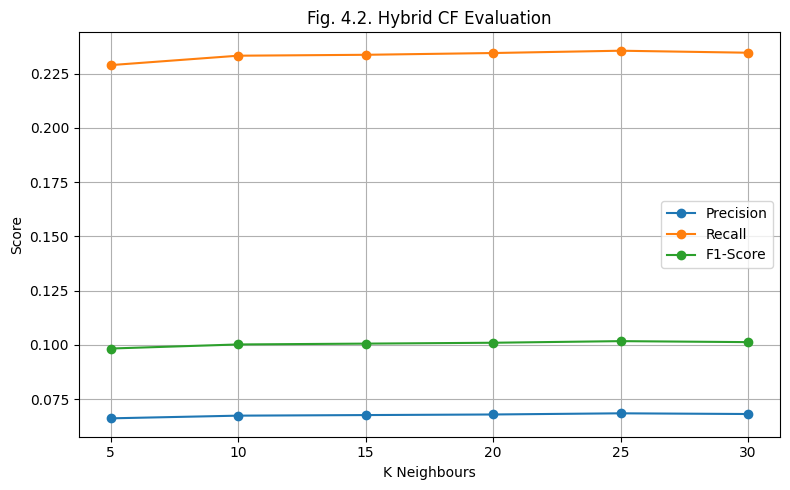

In [115]:
data = results_dict
x = list(data.keys())

# Prepare values
standard_precision = [data[k]['standard_cf']['precision'] for k in x]
standard_recall = [data[k]['standard_cf']['recall'] for k in x]
standard_f1 = [data[k]['standard_cf']['f1-score'] for k in x]

hybrid_precision = [data[k]['hybrid_cf']['precision'] for k in x]
hybrid_recall = [data[k]['hybrid_cf']['recall'] for k in x]
hybrid_f1 = [data[k]['hybrid_cf']['f1-score'] for k in x]

visualize_evaluation(x, standard_precision, standard_recall, standard_f1, "Fig. 4.1 Standard CF Evaluation")
visualize_evaluation(x, hybrid_precision, hybrid_recall, hybrid_f1, "Fig. 4.2. Hybrid CF Evaluation")

### 5. References

ChatGPT 1: OpenAI 2025 ChatGPT v4.o, "example item popularity distribution", Appendix A

ChatGPT 2: OpenAI 2025 ChatGPT v4.o, "multiple line in line chart plt", Appendix B

ChatGPT 3: OpenAI 2025 ChatGPT v4.o, "sns horizontal bar chart", Appendix C

### 6. Appendix

#### Appendix A

```
import pandas as pd
import matplotlib.pyplot as plt

# Example: replace with your actual data
data = {
    'user_id': [1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 6],
    'item_id': ['A', 'B', 'A', 'C', 'A', 'B', 'D', 'E', 'F', 'A', 'B']
}

# Create DataFrame
df = pd.DataFrame(data)

# Count the number of interactions per item
item_counts = df['item_id'].value_counts()

# Sort by popularity (descending) and reset index
item_counts_sorted = item_counts.sort_values(ascending=False).reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(item_counts_sorted.values)
plt.title("Item Popularity Distribution")
plt.xlabel("Item Rank")
plt.ylabel("Number of Interactions")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

```

#### Appendix B

```
import matplotlib.pyplot as plt

# Example data for the lines
x = [1, 2, 3, 4, 5]
y1 = [1, 4, 9, 16, 25]  # First line
y2 = [1, 2, 3, 4, 5]    # Second line

# Plot the first line with markers
plt.plot(x, y1, label='Line 1', color='blue', marker='o')

# Plot the second line with markers
plt.plot(x, y2, label='Line 2', color='red', marker='s')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Multiple Lines with Markers in a Line Chart')

# Show the legend
plt.legend()

# Display the plot
plt.show()

```

#### Appendix C

```
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
data = {
    'Category': ['A', 'B', 'C', 'D'],
    'Value': [23, 45, 56, 78]
}

# Convert the data into a DataFrame
import pandas as pd
df = pd.DataFrame(data)

# Create a horizontal bar chart by swapping x and y
sns.barplot(y='Category', x='Value', data=df)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Category')
plt.title('Horizontal Bar Chart Example')

# Show the plot
plt.show()

```